=== AdaBoost Results ===
Accuracy: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        48
           1       0.81      0.83      0.82        42

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90

Confusion Matrix:
 [[40  8]
 [ 7 35]]

=== Random Forest Results ===
Accuracy: 0.8555555555555555
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        48
           1       0.87      0.81      0.84        42

    accuracy                           0.86        90
   macro avg       0.86      0.85      0.85        90
weighted avg       0.86      0.86      0.86        90

Confusion Matrix:
 [[43  5]
 [ 8 34]]


d:\Desktop\BINF5507_Capstone\.pixi\envs\default\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


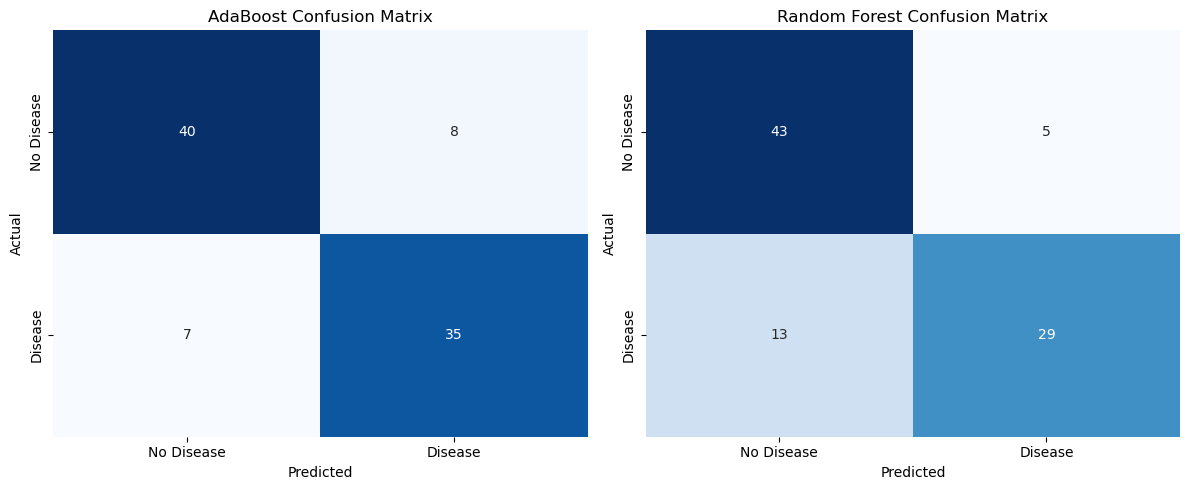

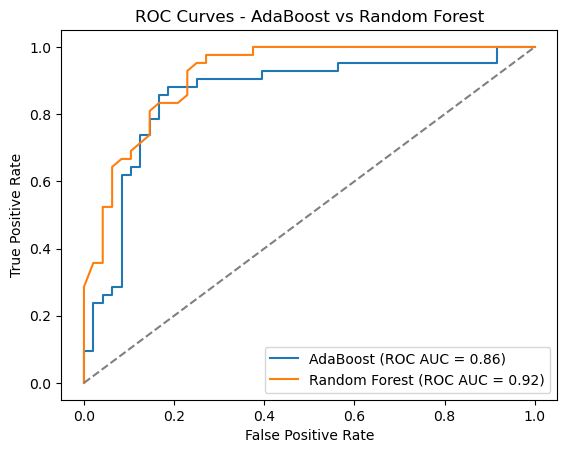

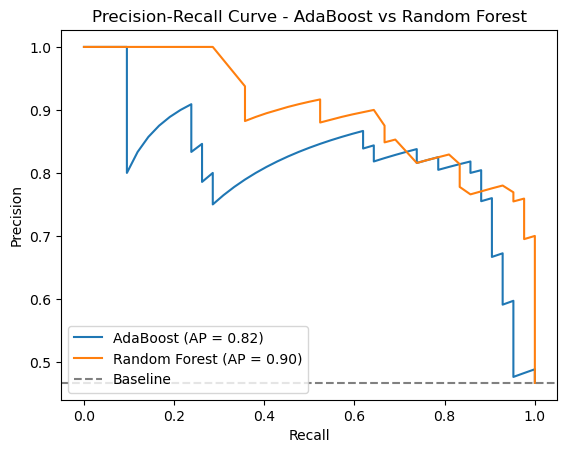

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay

# 1. Loading and Preprocessing of the Cleveland UCI Heart Disease Dataset 
df = pd.read_csv("../Data/processed.cleveland.data", header=None, na_values="?")

# Assign column names
df.columns = [
    "age", "sex", "cp", "trestbps", "chol",
    "fbs", "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "num"
]

# Drop missing values (AdaBoost isnt able to handle null values, as such the any missing values must be dropped or imputed if possible)
df.dropna(inplace=True)

# Convert 'num' to binary 'target' (0 => 0, 1-4 => 1)
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.drop("num", axis=1, inplace=True)

X = df.drop("target", axis=1)
y = df["target"]

# Train/Test Split (stratify to preserve label ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 2. Training AdaBoost and Random Forest models
# a) AdaBoost
base_est = DecisionTreeClassifier(max_depth=1, random_state=46)
ada_model = AdaBoostClassifier(
    estimator=base_est,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)

# b) Random Forest
rf_model = RandomForestClassifier(random_state=46)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 3. Visualizations
# -- Metrics for AdaBoost
print("=== AdaBoost Results ===")
print("Accuracy:", accuracy_score(y_test, ada_preds))
print("Classification Report:\n", classification_report(y_test, ada_preds))
ada_cm = confusion_matrix(y_test, ada_preds)
print("Confusion Matrix:\n", ada_cm)

# -- Metrics for Random Forest
print("\n=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))
rf_cm = confusion_matrix(y_test, rf_preds)
print("Confusion Matrix:\n", rf_cm)

# Optional: define class labels
labels = ["No Disease", "Disease"]

# Compute confusion matrices
cm_ada = confusion_matrix(y_test, y_pred_ada)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- AdaBoost Confusion Matrix ---
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=labels, yticklabels=labels)
axes[0].set_title("AdaBoost Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# --- Random Forest Confusion Matrix ---
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=labels, yticklabels=labels)
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ROC Curves
ada_probs = ada_model.predict_proba(X_test)[:, 1]  # Probability of the positive class
rf_probs  = rf_model.predict_proba(X_test)[:, 1]

fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_probs)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, rf_probs)

auc_ada = auc(fpr_ada, tpr_ada)
auc_rf  = auc(fpr_rf,  tpr_rf)

plt.figure()
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (ROC AUC = {auc_ada:.2f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (ROC AUC = {auc_rf:.2f})")

# Diagonal line to indicate "no skill" classifier
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - AdaBoost vs Random Forest")
plt.legend()
plt.show()

precision_ada, recall_ada, _ = precision_recall_curve(y_test, ada_probs)
precision_rf,  recall_rf,  _ = precision_recall_curve(y_test, rf_probs)

#  Precision-Recall Curves (AUPRC)
ap_ada = average_precision_score(y_test, ada_probs)
ap_rf  = average_precision_score(y_test, rf_probs)

plt.figure()
plt.plot(recall_ada, precision_ada, label=f"AdaBoost (AP = {ap_ada:.2f})")
plt.plot(recall_rf,  precision_rf,  label=f"Random Forest (AP = {ap_rf:.2f})")

# Horizontal line at the baseline (i.e., fraction of positives in data)
baseline = sum(y_test) / len(y_test)
plt.axhline(y=baseline, linestyle="--", color="gray", label="Baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - AdaBoost vs Random Forest")
plt.legend()
plt.show()
